In [2]:
#
# In this notebook we compute simple statistics
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.gridspec as gridspec
from scipy.special import logit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from global_land_mask import globe
from src.regions import *
from src.pf_stats import *
from src.plotting import *

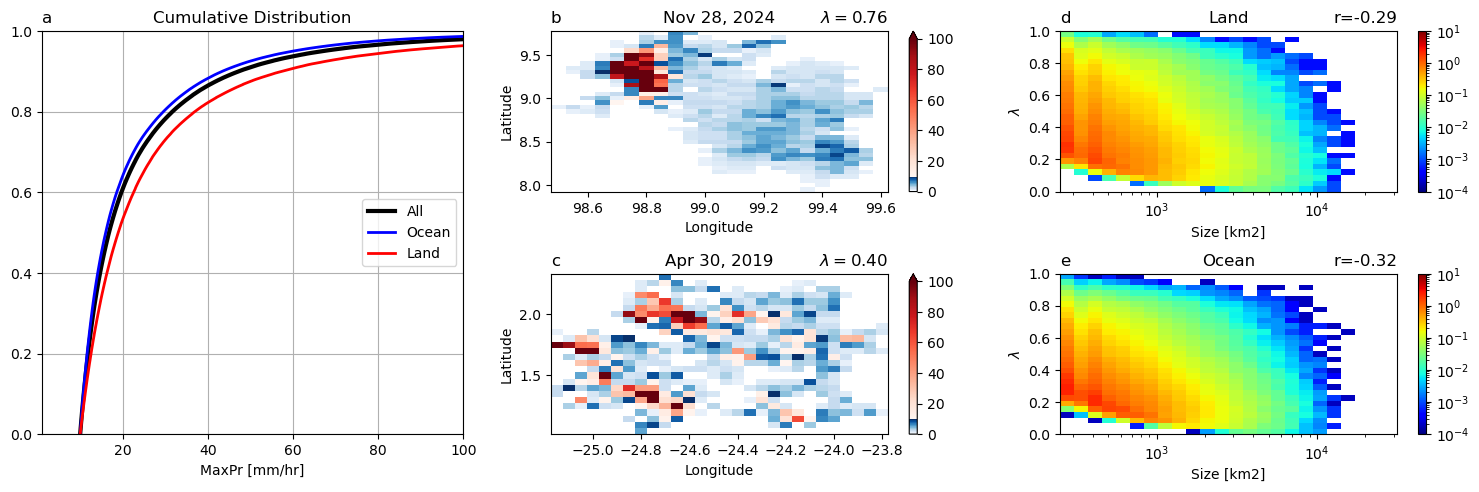

In [26]:

#
# Plot Figure 1 for paper
#
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(
    nrows=2,
    ncols=3, 
    width_ratios=[4, 4, 4],
    height_ratios=[1, 1]
)

#
# Plot CDF of MaxPr for land and ocean
#
ax = fig.add_subplot(gs[:, 0])
maxpr = pf_stats['max_precip']
is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
def cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return cdf

maxpr_all = pf_stats['max_precip'].values
maxpr_land = pf_stats['max_precip'][is_land_id].values
maxpr_ocean = pf_stats['max_precip'][is_ocean_id].values
ax.plot(np.sort(maxpr_all), cdf(maxpr_all), label='All', lw=3, color='black')
ax.plot(np.sort(maxpr_ocean), cdf(maxpr_ocean), label='Ocean', lw=2, color='blue')
ax.plot(np.sort(maxpr_land), cdf(maxpr_land), label='Land', lw=2, color='red')

ax.set_xlim(1, 100)
ax.set_ylim(0, 1)
ax.set_xlabel('MaxPr [mm/hr]')
ax.set_title('Cumulative Distribution')
ax.set_title('a', loc='left')
ax.legend(loc='center right')
ax.grid(True)

#
# Plot high and low locs
#
def create_split_cmap(vmin=0, vmax=100, split=10, cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm

cmap_split, norm_split = create_split_cmap(
    vmin=0,
    vmax=100,
    split=10,
    cmap_low=plt.cm.Blues,
    cmap_high=plt.cm.Reds
)

ax_list = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]
regime_list = ['high_area_high_loc', 'high_area_low_loc']

for i, (ax, regime) in enumerate(zip(ax_list, regime_list)):
    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data = xr.open_dataset(pf_filename)
    pf_data.near_surf_rain.plot(
        ax=ax,
        cmap=cmap_split,
        norm=norm_split,
        cbar_kwargs={'label': None}
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title('')
    ax.set_title(chr(ord('b') + i), loc='left')
    ax.set_title(pf_data.time.dt.strftime('%b %d, %Y').item())
    ax.set_title(rf'$\lambda=${[0.76, 0.40][i]:.02f}', loc='right')

#
# Plot PDF of land size and loc
#
ax = fig.add_subplot(gs[0, 2])
area = pf_stats[is_land_id]['num_pixels'] * 25
loc = pf_stats[is_land_id][f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats[is_land_id]['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic
pdf = 100*count / count.sum()
x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.jet, 
        norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
    )   
)

fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel(r'Size [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PDF [%]')
ax.set_title('d', loc='left')
ax.set_title('Land', loc='center')

# Compute Pearson's r for land (area vs. loc) and place in title (right)
r_val_land, p_val_land = pearsonr(area, loc)
ax.set_title(f'r={r_val_land:.2f}', loc='right')

#
# Plot PDF of ocean size and loc
#
ax = fig.add_subplot(gs[1, 2])
area = pf_stats[is_ocean_id]['num_pixels'] * 25
loc = pf_stats[is_ocean_id][f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats[is_ocean_id]['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic
pdf = 100*count / count.sum()
x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
c = (
    ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.jet, 
        norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
    )   
)

# Compute Pearson's r for ocean (area vs. loc) and place in title (right)
r_val_ocean, p_val_ocean = pearsonr(area, loc)

fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel(r'Size [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PDF [%]')
ax.set_title('e', loc='left')
ax.set_title('Ocean', loc='center')
ax.set_title(f'r={r_val_ocean:.2f}', loc='right')

#
# Final figure params
#
fig.tight_layout(pad=1)
save_figure(fig, 'Fig01_CDFandExamplePS')

In [27]:
p_val_land

0.0

In [28]:
p_val_ocean

0.0